In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics, regularizers
from keras.utils import to_categorical


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 500)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_csv('2000-2018_disasters_min50k_for_modeling.csv')
df.drop(columns = ['BEGIN_DATE_TIME','END_DATE_TIME','BEGIN_TIME','END_TIME'], inplace = True)
df.head()

,STATE,CZ_TYPE,EVENT_TYPE,CZ_TIMEZONE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,MAGNITUDE_TYPE,MAGNITUDE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,YEAR,BEGIN_MONTH,BEGIN_DAY,END_MONTH,END_DAY,DURATION_DAYS,DURATION_HOURS,DURATION_MINUTES,TOTAL_DURATION_HR,DISTANCE_COVERED(KM),BEGIN_HOUR,BEGIN_MINUTE,END_HOUR,END_MINUTE
0,MISSOURI,C,Thunderstorm Wind,CST,3,0,0,0,250000.0,0.0,1.0,E,0.0,N,E,83.0,37.25,-89.67,37.30,-89.53,2000,1,3,1,3,0,0,10,0.2,16.651331,8,50,9,0
1,ILLINOIS,C,Thunderstorm Wind,CST,0,0,0,0,150000.0,0.0,2.0,NE,4.0,NE,E,100.0,37.73,-89.18,37.75,-89.17,2000,1,3,1,3,0,0,4,0.1,4.535308,9,18,9,22
2,ILLINOIS,C,Thunderstorm Wind,CST,0,0,0,0,100000.0,0.0,1.0,S,4.0,NE,E,75.0,37.78,-89.12,37.78,-89.12,2000,1,3,1,3,0,0,2,0.0,0.000000,9,22,9,24
3,INDIANA,C,Thunderstorm Wind,CST,0,0,0,0,100000.0,0.0,0.0,E,0.0,E,E,65.0,37.98,-87.55,37.98,-87.55,2000,1,3,1,3,0,0,0,0.0,0.000000,12,10,12,10
4,ILLINOIS,C,Thunderstorm Wind,CST,0,0,0,0,100000.0,0.0,0.0,E,1.0,E,E,87.0,37.73,-88.93,37.73,-88.93,2000,1,3,1,3,0,0,0,0.0,0.000000,14,7,14,7


In [3]:
df['EVENT_TYPE'].value_counts()

Thunderstorm Wind           8085
Hail                        2944
Tornado                        5
Marine Thunderstorm Wind       5
Marine High Wind               4
Marine Strong Wind             2
Flash Flood                    2
Name: EVENT_TYPE, dtype: int64

In [4]:
features = ['BEGIN_RANGE', 'MAGNITUDE', 'BEGIN_AZIMUTH',
            'BEGIN_MONTH', 'END_MONTH', 'TOTAL_DURATION_HR', 'DISTANCE_COVERED(KM)', 'BEGIN_HOUR', 'STATE']

len(features)

9

In [5]:
# function to calculate r^2 of my neural network
def r_square(X_test,y_test):
    y_pred = model.predict(X_test).reshape(y_test.shape[0])
    y_test = np.array(y_test)
    ss_res = np.sum(np.square(y_test - y_pred))
    y_mean = np.full((1, y_test.shape[0]),y_test.mean())
    ss_tot = np.sum(np.square(y_mean - y_test))
    return 1-ss_res/ss_tot

# Hail events

In [6]:
hail = df[df['EVENT_TYPE'] == 'Hail']
hail.shape

(2944, 34)

In [7]:
hail['MAGNITUDE'].min()

0.25

In [8]:
hail['MAGNITUDE'].max()

7.0

In [9]:
hail['DAMAGE_PROPERTY'].min()

51000.0

In [10]:
hail['DAMAGE_PROPERTY'].max()

2300000000.0

In [11]:
hail[hail['DAMAGE_PROPERTY'] == hail['DAMAGE_PROPERTY'].max()]

,STATE,CZ_TYPE,EVENT_TYPE,CZ_TIMEZONE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,MAGNITUDE_TYPE,MAGNITUDE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,YEAR,BEGIN_MONTH,BEGIN_DAY,END_MONTH,END_DAY,DURATION_DAYS,DURATION_HOURS,DURATION_MINUTES,TOTAL_DURATION_HR,DISTANCE_COVERED(KM),BEGIN_HOUR,BEGIN_MINUTE,END_HOUR,END_MINUTE
10512,COLORADO,C,Hail,MST-7,0,0,0,0,2.300000e+09,0.0,1.0,N,1.0,N,HA,2.75,39.77,-105.1,39.77,-105.1,2017,5,8,5,8,0,0,0,0.0,0.0,14,5,14,5


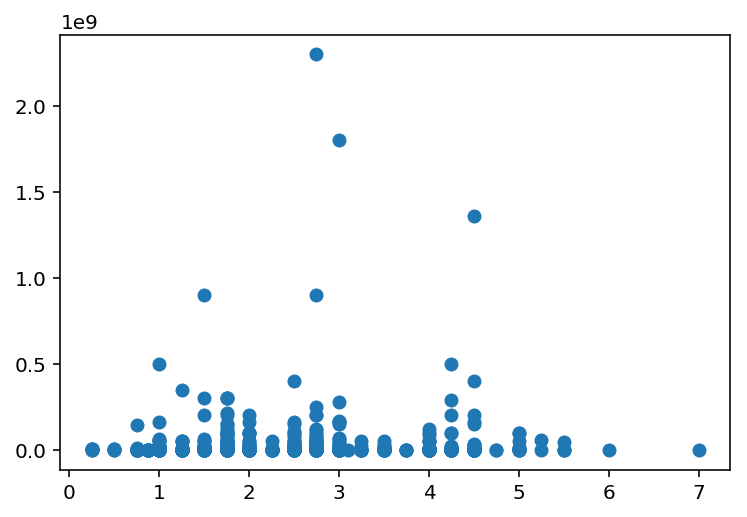

In [12]:
plt.scatter(hail['MAGNITUDE'], hail['DAMAGE_PROPERTY'])

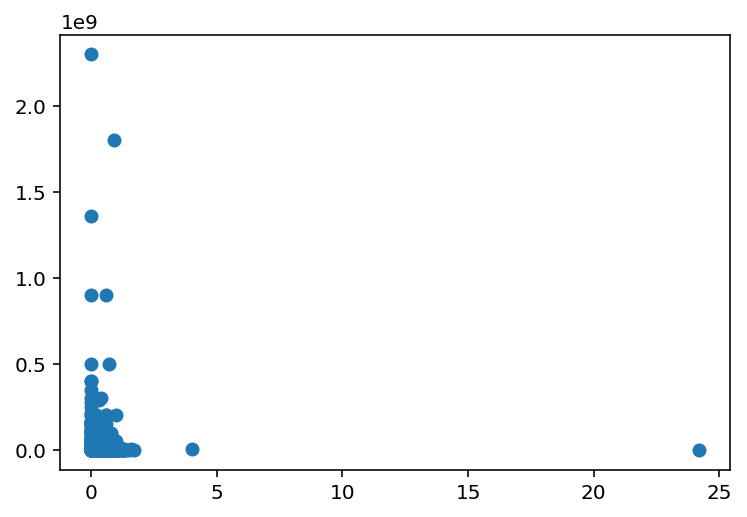

In [13]:
plt.scatter(hail['TOTAL_DURATION_HR'], hail['DAMAGE_PROPERTY'])

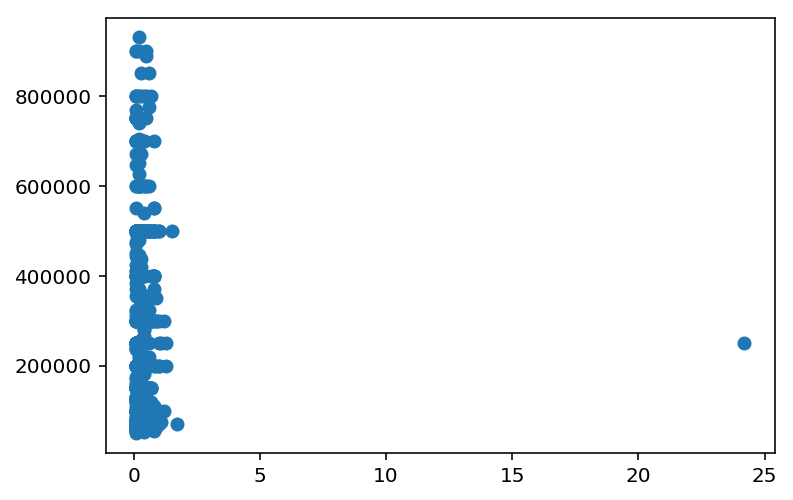

In [14]:
hail = hail[(hail['DAMAGE_PROPERTY']<1000000) & (hail['TOTAL_DURATION_HR']>0) ]
plt.scatter(hail['TOTAL_DURATION_HR'], hail['DAMAGE_PROPERTY'])

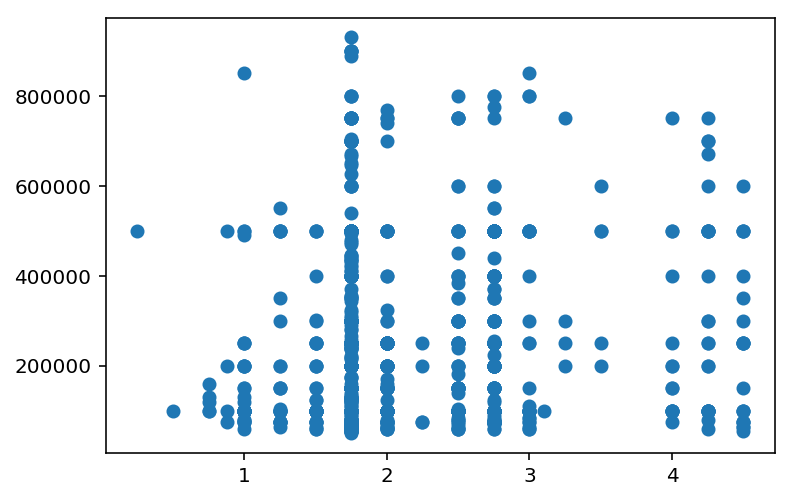

In [15]:
plt.scatter(hail['MAGNITUDE'], hail['DAMAGE_PROPERTY'])

In [16]:
X = hail[features]
X = pd.get_dummies(X)
y = hail['DAMAGE_PROPERTY']

X.head()

,BEGIN_RANGE,MAGNITUDE,BEGIN_MONTH,END_MONTH,TOTAL_DURATION_HR,DISTANCE_COVERED(KM),BEGIN_HOUR,BEGIN_AZIMUTH_E,BEGIN_AZIMUTH_ENE,BEGIN_AZIMUTH_ESE,BEGIN_AZIMUTH_N,BEGIN_AZIMUTH_NE,BEGIN_AZIMUTH_NNE,BEGIN_AZIMUTH_NNW,BEGIN_AZIMUTH_NW,BEGIN_AZIMUTH_S,BEGIN_AZIMUTH_SE,BEGIN_AZIMUTH_SSE,BEGIN_AZIMUTH_SSW,BEGIN_AZIMUTH_SW,BEGIN_AZIMUTH_W,BEGIN_AZIMUTH_WNW,BEGIN_AZIMUTH_WSW,STATE_ALABAMA,STATE_ARIZONA,STATE_ARKANSAS,STATE_CALIFORNIA,STATE_COLORADO,STATE_CONNECTICUT,STATE_FLORIDA,STATE_GEORGIA,STATE_IDAHO,STATE_ILLINOIS,STATE_INDIANA,STATE_IOWA,STATE_KANSAS,STATE_KENTUCKY,STATE_LOUISIANA,STATE_MASSACHUSETTS,STATE_MICHIGAN,STATE_MINNESOTA,STATE_MISSISSIPPI,STATE_MISSOURI,STATE_MONTANA,STATE_NEBRASKA,STATE_NEW JERSEY,STATE_NEW MEXICO,STATE_NEW YORK,STATE_NORTH CAROLINA,STATE_NORTH DAKOTA,STATE_OHIO,STATE_OKLAHOMA,STATE_PENNSYLVANIA,STATE_PUERTO RICO,STATE_SOUTH CAROLINA,STATE_SOUTH DAKOTA,STATE_TENNESSEE,STATE_TEXAS,STATE_UTAH,STATE_VERMONT,STATE_VIRGINIA,STATE_WEST VIRGINIA,STATE_WISCONSIN,STATE_WYOMING
26,0.0,1.50,3,3,0.6,34.393638,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38,6.0,1.50,3,3,0.5,22.758296,21,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
41,4.0,4.50,3,3,0.2,0.000000,17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
42,6.0,3.50,3,3,0.2,0.000000,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
47,2.0,1.75,3,3,0.4,15.691054,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


(array([274., 612., 874., 343., 283., 288., 237., 235.,  48.,  86.]),
 array([10.83958091, 11.13443676, 11.4292926 , 11.72414845, 12.01900429,
        12.31386014, 12.60871598, 12.90357183, 13.19842767, 13.49328352,
        13.78813936]),
 <a list of 10 Patch objects>)

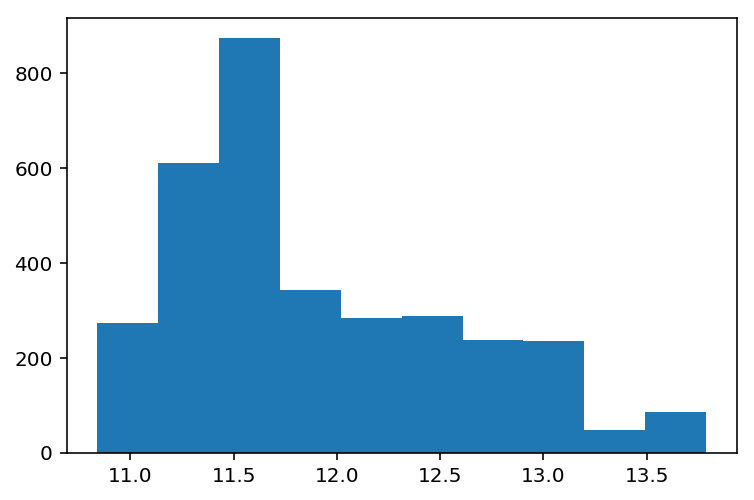

In [44]:
plt.hist(np.log(y))

In [17]:
X.shape

(939, 64)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 18)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [21]:
model = Sequential()

# input layer 
model.add(Dense(64, activation = 'relu', input_dim = X_train.shape[1]))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.3))

# output layer
model.add(Dense(1, activation = None))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5000, verbose = 0)

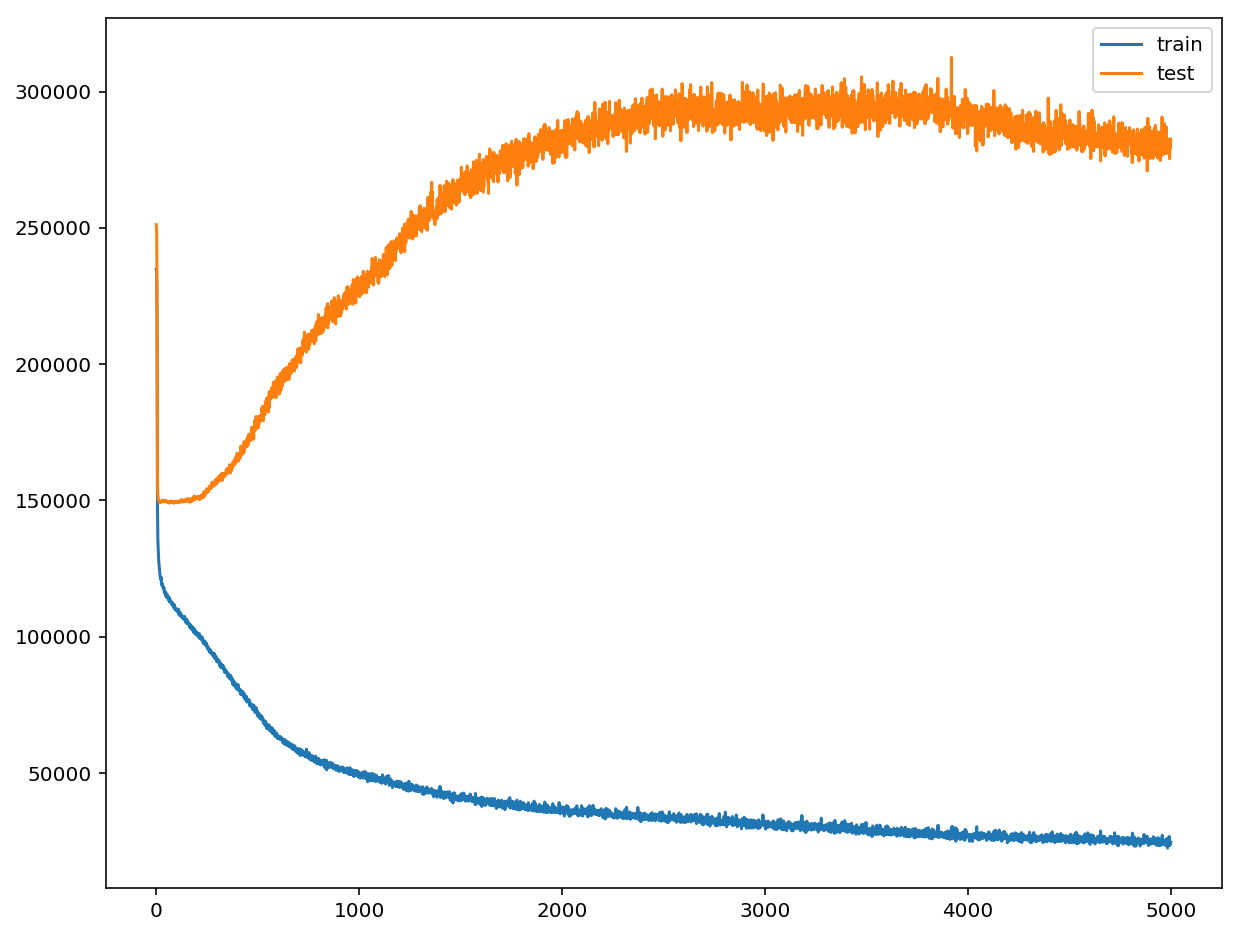

In [22]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [23]:
r_square(X_train, y_train)

0.91770985731112

In [24]:
r_square(X_test, y_test)

-3.644970710069443

# Thunderstorm wind events

In [25]:
thun = df[df['EVENT_TYPE'] == 'Thunderstorm Wind']
thun.shape

(8085, 34)

In [26]:
thun['DAMAGE_PROPERTY'].min()

51000.0

In [27]:
thun['DAMAGE_PROPERTY'].max()

750000000.0

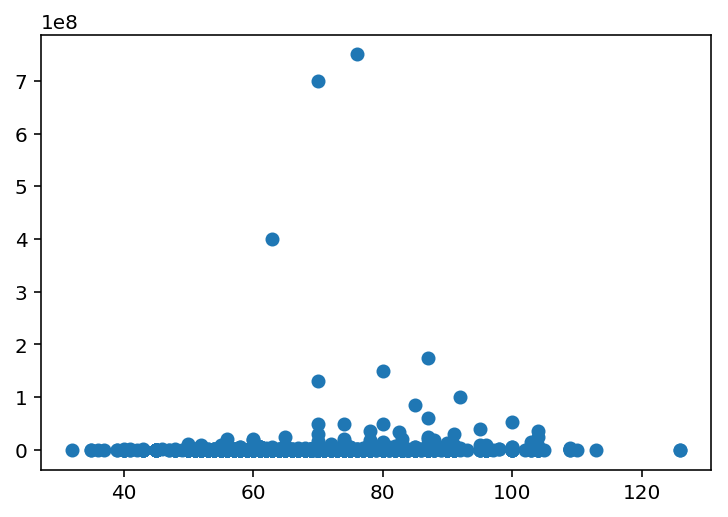

In [28]:
plt.scatter(thun['MAGNITUDE'], thun['DAMAGE_PROPERTY'])

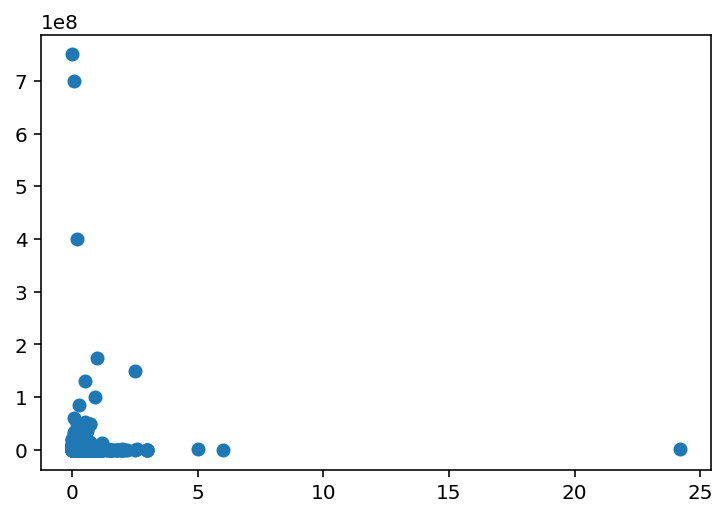

In [29]:
plt.scatter(thun['TOTAL_DURATION_HR'], thun['DAMAGE_PROPERTY'])

In [30]:
thun = thun[(thun['DAMAGE_PROPERTY']<1000000) & (thun['TOTAL_DURATION_HR']>0)]

In [31]:
thun.shape

(3280, 34)

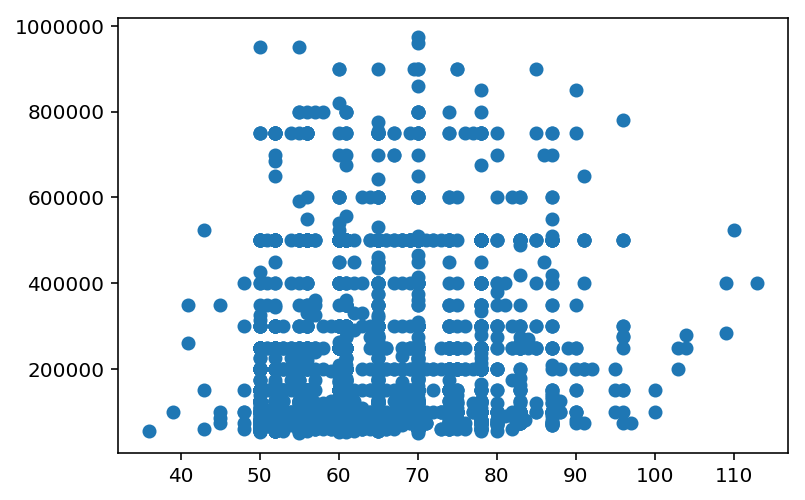

In [32]:
plt.scatter(thun['MAGNITUDE'], thun['DAMAGE_PROPERTY'])

(-0.1, 3)

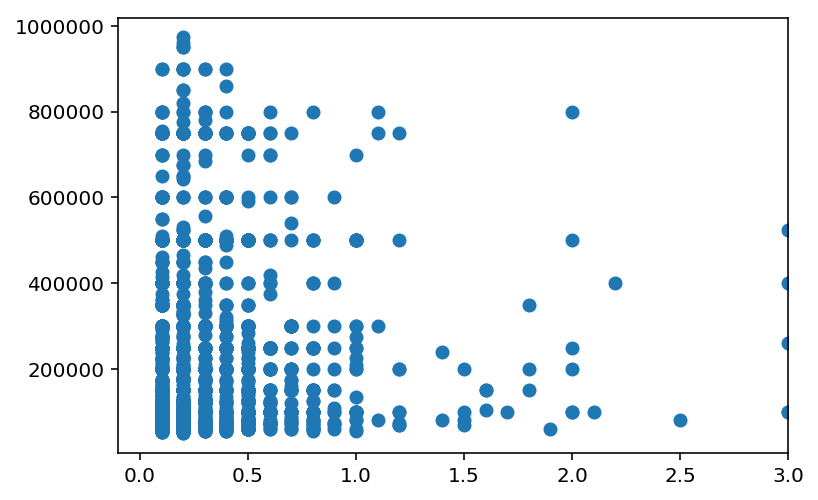

In [33]:
plt.scatter(thun['TOTAL_DURATION_HR'], thun['DAMAGE_PROPERTY'])
plt.xlim(-0.1,3)

In [34]:
X = thun[features]
X = pd.get_dummies(X)
y = thun['DAMAGE_PROPERTY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [35]:
X_train.shape

(2460, 72)

In [42]:
model = Sequential()

# input layer 
model.add(Dense(72, activation = 'relu', input_dim = X_train.shape[1]))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.5))

# adding a hidden layer 
model.add(Dense(500, activation = 'relu'))

model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation = None))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10000, verbose = 0)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [ ]:
r_square(X_train, y_train)

In [ ]:
r_square(X_test, y_test)